In [13]:
using Plots
using LaTeXStrings
using Base.Threads
nthreads()

1

In [2]:
include("TN_Superfermionic_Mesoscopic_Leads/Code/Interacting_functions.jl")

This package is totally compatible with gpu. If you want to use GPU, just define GPU = true as a global variable in your code.


Energy_Current_HS_time_dependent

In [3]:
precompile_package("TN_Superfermionic_Mesoscopic_Leads", false) #GPU = false
# precompile_package("TN_Superfermionic_Mesoscopic_Leads", true) #GPU = true

The package has been precompiled for GPU = false.
 62.038922 seconds (158.95 M allocations: 13.053 GiB, 4.13% gc time, 96.74% compilation time: 3% of which was recompilation)


In [4]:
using LinearAlgebra
using FlexiMaps

W = 8.0
Γ = W/8
J(ω) = abs(ω) <= abs(W) ? Γ : 0 #Spectral density Γ = W/8 in this case

#Lead
εk = [-0.5, 0.5]
L = length(εk)
γk = [εk[k+1] - εk[k] for k=1:Int(L/2)] 
append!(γk, reverse(γk)) #It agrees with [1.0, 1.0] of the article
κkp = ComplexF64[sqrt(J(εk[k])*γk[k]/(2.0*pi)) for k=1:L];

Let's see that we can reproduce the same effective spectral function of the article's inset.

εk = [-0.5, 0.5]
γk = [1.0, 1.0]
κkp = ComplexF64[0.3989422804014327 + 0.0im, 0.3989422804014327 + 0.0im]


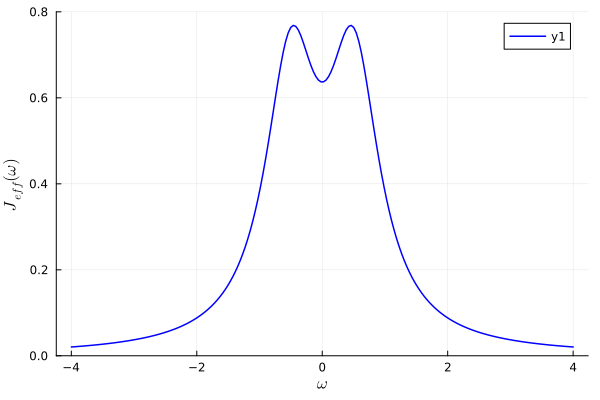

In [5]:
function J_eff(εk::Vector{Float64}, γk::Vector{Float64}, κkp::Vector{ComplexF64}, ω::Float64)
    
    Value = 0
    for i=1:length(εk) #1,...,L
        Value += (abs(κkp[i])^2)*γk[i]/((ω - εk[i])^2 + (γk[i]/2)^2)
    end
    return Value
end  

ω_domain = LinRange(-4,4,200) #X Axis
J_effective = [J_eff(εk, γk, κkp, ω) for ω=ω_domain] #Here we are using the function of the library.

@show εk
@show γk
@show κkp

plot(ω_domain, J_effective, color = "blue", ylabel = L"J_{eff}(\omega)", xlabel = L"\omega",linewidth = 1.5, ylim = (0, 0.8))

Now, let's try to find the NESS for Forward and Reverse Bias

In [6]:
function fk_arrays(εk_array_L, εk_array_R)
    
    fk_array_L = [fermi_dirac_distribution(ε, μ_L, β_L) for ε = εk_array_L]
    fk_array_R = [fermi_dirac_distribution(ε, μ_R, β_R) for ε = εk_array_R]
    
    return fk_array_L, fk_array_R
end

fk_arrays (generic function with 1 method)

In [7]:
#System
N = 4
ts = (W/8) # W/8 = 1. It is like multiply equation 1 by 2. Them=n interaction should be also two times Δ.
U = 10*ts # U = 2Δ because we need U/ts = 5/0.5 = 10/1 as in the article
# ts = 0.5
# U = 5.0
β_L, β_R = 1/(10), 1/(10)

# μ_L, μ_R = 100.0, -100.0 #Forward
μ_L, μ_R = -100.0, 100.0 #Reverse
fk_L , fk_R = fk_arrays(εk, εk)

E = 4.0
μ = -E*(N+1)/4

ε_array = Float64[]

for i=1:N
    value = (μ + 0.5*E*i)
    i==1 || i==N ? value+= -0.5*U : value+= -U
    append!(ε_array, value)
end

In [8]:
GPU = false 

L = length(εk)
R = L
D = N

M = L + D + R

sites = siteinds("S=1/2",2*M)
I_vec = Build_left_vacuum(sites);
Psi_0 = I_vec;

dt = 0.05
NumSteps = 1000
maxdim = 20
cutoff = 10e-8
Measurements = ["JP"]
Percentage_for_measurement = 1.0
Params = Params_for_Measurements(Percentage_for_measurement, εk, γk, κkp, fk_L, εk, γk, κkp, fk_R, ε_array, ts, U, dt); #Empty arrays are for left lead and 0.0 are for ts, U
Swap_Gates, TEBD_Gates = Build_Gates(sites, εk, γk, 0.0*κkp, fk_L, εk, γk, 0.0*κkp, fk_R, ε_array, ts, U, dt);
@time Thermal_state, observables = Apply_TEBD(I_vec, I_vec, Swap_Gates, TEBD_Gates, NumSteps, maxdim, cutoff, Measurements, Params); #maxdim = 40 by default
@show observables.JP_t[end]
# @show observables.JE_t[end];

10.0 % Completed.
20.0 % Completed.
30.0 % Completed.
40.0 % Completed.
50.0 % Completed.
60.0 % Completed.
70.0 % Completed.
80.0 % Completed.
90.0 % Completed.
100.0 % Completed.
 13.528599 seconds (74.90 M allocations: 19.412 GiB, 9.23% gc time, 8.51% compilation time: 83% of which was recompilation)
observables.JP_t[end] = 9.090924025043326e-5


9.090924025043326e-5

In [9]:
# GPU = true
# I_vec = gpu(I_vec)
# Thermal_state = gpu(Thermal_state)

dt = 0.1
NumSteps = 1000
Params = Params_for_Measurements(Percentage_for_measurement, εk, γk, κkp, fk_L, εk, γk, κkp, fk_R, ε_array, ts, U, dt); #Empty arrays are for left lead and 0.0 are for ts, U
Swap_Gates, TEBD_Gates = Build_Gates(sites, εk, γk, κkp, fk_L, εk, γk, κkp, fk_R, ε_array, ts, U, dt);
@time NESS, observables = Apply_TEBD(Thermal_state, I_vec, Swap_Gates, TEBD_Gates, NumSteps, maxdim, cutoff, Measurements, Params); #maxdim = 40 by default
@show observables.JP_t[end]
# @show observables.JE_t[end];
@show maxlinkdim(NESS);

10.0 % Completed.
20.0 % Completed.
30.0 % Completed.
40.0 % Completed.
50.0 % Completed.
60.0 % Completed.
70.0 % Completed.
80.0 % Completed.
90.0 % Completed.
100.0 % Completed.
 82.490001 seconds (74.17 M allocations: 37.042 GiB, 1.71% gc time)
observables.JP_t[end] = -0.0023388469203162914
maxlinkdim(NESS) = 20


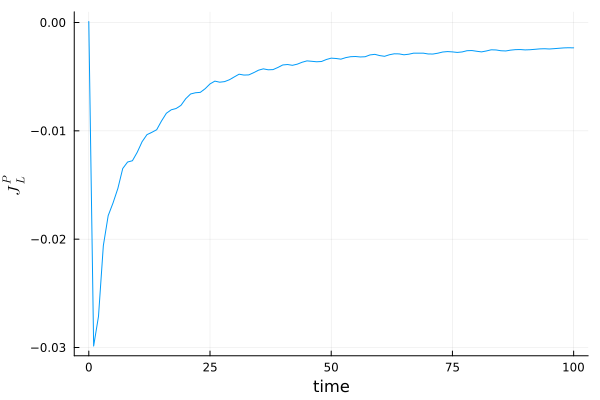

In [10]:
p1 = plot(observables.time, observables.JP_t, ylabel = L"J^{P}_{L}", xlabel = "time", label = false)
# p2 = plot(observables.time, observables.JE_t, ylabel = L"J^{E}_{L}", xlabel = "time", label = false)
# plot(p1, p2, size = (1200,500), margin=5Plots.mm)

In [11]:
J0 = 2/(1^2 +16)

observables.JP_t[end]/J0

-0.019880198822688478

In [79]:
# GPU = true
# I_vec = gpu(I_vec)
# Thermal_state = gpu(Thermal_state)

dt = 0.01
NumSteps = 1000
Params = Params_for_Measurements(Percentage_for_measurement, εk, γk, κkp, fk_L, εk, γk, κkp, fk_R, ε_array, ts, U, dt); #Empty arrays are for left lead and 0.0 are for ts, U
Swap_Gates, TEBD_Gates = Build_Gates(sites, εk, γk, κkp, fk_L, εk, γk, κkp, fk_R, ε_array, ts, U, dt);
@time NESS, observables2 = Apply_TEBD(NESS, I_vec, Swap_Gates, TEBD_Gates, NumSteps, maxdim, cutoff, Measurements, Params); #maxdim = 40 by default
@show observables2.JP_t[end]
# @show observables2.JE_t[end];
@show maxlinkdim(NESS);

10.0 % Completed.
20.0 % Completed.
30.0 % Completed.
40.0 % Completed.
50.0 % Completed.
60.0 % Completed.
70.0 % Completed.
80.0 % Completed.
90.0 % Completed.
100.0 % Completed.
365.624822 seconds (69.52 M allocations: 76.044 GiB, 0.95% gc time)
observables2.JP_t[end] = 0.012819009662447867
maxlinkdim(NESS) = 40


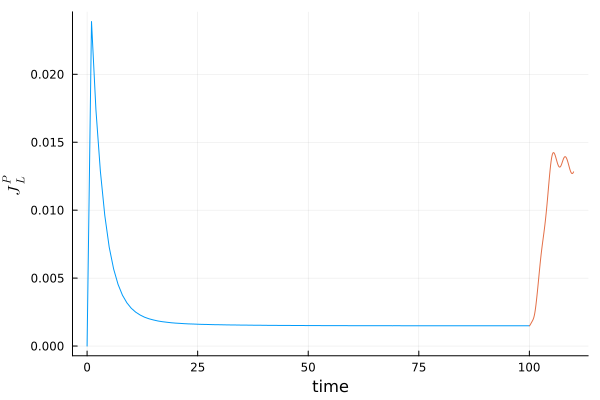

In [83]:
plot(observables.time*2, observables.JP_t, ylabel = L"J^{P}_{L}", xlabel = "time", label = false)
plot!(observables2.time/5 .+ observables.time[end]*2, observables2.JP_t, label = false)

In [ ]:
### Final version with Multithreading

In [12]:
GPU = false

#Leads
εk = [-0.5, 0.5]
L = length(εk)
γk = [εk[k+1] - εk[k] for k=1:Int(L/2)] 
append!(γk, reverse(γk)) #It agrees with [1.0, 1.0] of the article
κkp = ComplexF64[sqrt(J(εk[k])*γk[k]/(2.0*pi)) for k=1:L];

#System
N = 4
ts = 0.5
U = 5.0
β_L, β_R = 1/(10), 1/(10)

#TN Method Variables

R = L
D = N
M = L + D + R
sites = siteinds("S=1/2",2*M)
I_vec = Build_left_vacuum(sites)
maxdim = 20
cutoff = 10e-8
Measurements = ["JP"]
Percentage_for_measurement = 1.0

#Tilted Energies

Results = Dict()

# E_values = [2.0, 4.0, 6.0, 8.0] 
# E_values = LinRange(0, 12, 10)
E_values = LinRange(0, 1.8, 10)

@time begin
@threads for i=1:min(nthreads(), length(E_values))
# for i=1:min(nthreads(), length(E_values))
    # E = 2.0
    E = E_values[i]
    E_for_file = round(E; digits = 4)
    
    μ = -E*(N+1)/4
    ε_array = Float64[]
    for i=1:N
        value = (μ + 0.5*E*i)
        i==1 || i==N ? value+= -0.5*U : value+= -U
        append!(ε_array, value)
    end
    
    Observables_dict = Dict()
    
    Bias_list = ["Forward", "Reverse"]
    # @threads for i=1:min(nthreads(), length(Bias_list)) #30 segs each E for 200 steps.
    for i=1:min(nthreads(), length(Bias_list))
        global PRINT
        
        Bias = Bias_list[i]
    
        if Bias == "Forward" 
            μ_L, μ_R = 100.0, -100.0 
        else    
            μ_L, μ_R = -100.0, 100.0 #Reverse
        end
    
        #Let's calculate the fermi-dirac distributions.
        fk_L = [fermi_dirac_distribution(ε, μ_L, β_L) for ε = εk]
        fk_R = [fermi_dirac_distribution(ε, μ_R, β_R) for ε = εk]
    
        #First we need to find the Thermal State
        Psi_0 = I_vec #Initial state
        
        dt = 0.05
        NumSteps = 1000
        Params = Params_for_Measurements(Percentage_for_measurement, εk, γk, κkp, fk_L, εk, γk, κkp, fk_R, ε_array, ts, U, dt); #Empty arrays are for left lead and 0.0 are for ts, U
        Swap_Gates, TEBD_Gates = Build_Gates(sites, εk, γk, 0.0*κkp, fk_L, εk, γk, 0.0*κkp, fk_R, ε_array, ts, U, dt);
        PRINT = false
        Thermal_state, observables = Apply_TEBD(I_vec, I_vec, Swap_Gates, TEBD_Gates, NumSteps, maxdim, cutoff, Measurements, Params); 
        println("Thermal State calculated for E = $E_for_file and Bias = $Bias")
        # @show observables.JP_t[end] 
    
        #Now we can use this as start point to find the NESS
        dt = 0.1
        NumSteps = 20000
        # PRINT = true
        Params = Params_for_Measurements(Percentage_for_measurement, εk, γk, κkp, fk_L, εk, γk, κkp, fk_R, ε_array, ts, U, dt); #Empty arrays are for left lead and 0.0 are for ts, U
        Swap_Gates, TEBD_Gates = Build_Gates(sites, εk, γk, κkp, fk_L, εk, γk, κkp, fk_R, ε_array, ts, U, dt);

        path = "Local_Data/Appendix/E = $E_for_file Bias = $Bias"
        @time NESS, observables = Apply_TEBD(Thermal_state, I_vec, Swap_Gates, TEBD_Gates, NumSteps, maxdim, cutoff, Measurements, Params, path); #maxdim = 40 by default
        println("NESS calculated for E = $E_for_file and Bias = $Bias")
        # @show observables.JP_t[end]
        # @show maxlinkdim(NESS)
        Observables_dict[Bias] = observables
    
    end
    Results[E] = Observables_dict
    @show R = -Observables_dict["Forward"].JP_t[end]/Observables_dict["Reverse"].JP_t[end]
end
end

Thermal State calculated for E = 0.4 and Bias = Forward
Thermal State calculated for E = 0.6 and Bias = Forward
Thermal State calculated for E = 1.2 and Bias = Forward
Thermal State calculated for E = 0.8 and Bias = Forward
Thermal State calculated for E = 0.2 and Bias = Forward
Thermal State calculated for E = 1.0 and Bias = Forward
Thermal State calculated for E = 0.0 and Bias = Forward
Thermal State calculated for E = 1.8 and Bias = Forward
Thermal State calculated for E = 1.6 and Bias = Forward
Thermal State calculated for E = 1.4 and Bias = Forward
1248.501702 seconds (10.52 G allocations: 3.830 TiB, 42.29% gc time, 0.09% compilation time: 5% of which was recompilation)
NESS calculated for E = 0.2 and Bias = Forward
Thermal State calculated for E = 0.2 and Bias = Reverse
1301.555635 seconds (11.01 G allocations: 4.000 TiB, 42.27% gc time, 0.09% compilation time: 5% of which was recompilation)
NESS calculated for E = 0.4 and Bias = Forward
Thermal State calculated for E = 0.4 and B

In [13]:
E_values = LinRange(2.0, 3.8, 10)

@time begin
@threads for i=1:min(nthreads(), length(E_values))
# for i=1:min(nthreads(), length(E_values))


    # E = 2.0
    E = E_values[i]
    E_for_file = round(E; digits = 4)
    
    μ = -E*(N+1)/4
    ε_array = Float64[]
    for i=1:N
        value = (μ + 0.5*E*i)
        i==1 || i==N ? value+= -0.5*U : value+= -U
        append!(ε_array, value)
    end
    
    Observables_dict = Dict()
    
    Bias_list = ["Forward", "Reverse"]
    # @threads for i=1:min(nthreads(), length(Bias_list)) #30 segs each E for 200 steps.
    for i=1:min(nthreads(), length(Bias_list))
        global PRINT
        
        Bias = Bias_list[i]
    
        if Bias == "Forward" 
            μ_L, μ_R = 100.0, -100.0 
        else    
            μ_L, μ_R = -100.0, 100.0 #Reverse
        end
    
        #Let's calculate the fermi-dirac distributions.
        fk_L = [fermi_dirac_distribution(ε, μ_L, β_L) for ε = εk]
        fk_R = [fermi_dirac_distribution(ε, μ_R, β_R) for ε = εk]
    
        #First we need to find the Thermal State
        Psi_0 = I_vec #Initial state
        
        dt = 0.05
        NumSteps = 1000
        Params = Params_for_Measurements(Percentage_for_measurement, εk, γk, κkp, fk_L, εk, γk, κkp, fk_R, ε_array, ts, U, dt); #Empty arrays are for left lead and 0.0 are for ts, U
        Swap_Gates, TEBD_Gates = Build_Gates(sites, εk, γk, 0.0*κkp, fk_L, εk, γk, 0.0*κkp, fk_R, ε_array, ts, U, dt);
        PRINT = false
        Thermal_state, observables = Apply_TEBD(I_vec, I_vec, Swap_Gates, TEBD_Gates, NumSteps, maxdim, cutoff, Measurements, Params); 
        println("Thermal State calculated for E = $E_for_file and Bias = $Bias")
        # @show observables.JP_t[end] 
    
        #Now we can use this as start point to find the NESS
        dt = 0.1
        NumSteps = 20000
        # PRINT = true
        Params = Params_for_Measurements(Percentage_for_measurement, εk, γk, κkp, fk_L, εk, γk, κkp, fk_R, ε_array, ts, U, dt); #Empty arrays are for left lead and 0.0 are for ts, U
        Swap_Gates, TEBD_Gates = Build_Gates(sites, εk, γk, κkp, fk_L, εk, γk, κkp, fk_R, ε_array, ts, U, dt);

        path = "Local_Data/Appendix/E = $E_for_file Bias = $Bias"
        @time NESS, observables = Apply_TEBD(Thermal_state, I_vec, Swap_Gates, TEBD_Gates, NumSteps, maxdim, cutoff, Measurements, Params, path); #maxdim = 40 by default
        println("NESS calculated for E = $E_for_file and Bias = $Bias")
        # @show observables.JP_t[end]
        # @show maxlinkdim(NESS)
        Observables_dict[Bias] = observables
    
    end
    Results[E] = Observables_dict
    @show R = -Observables_dict["Forward"].JP_t[end]/Observables_dict["Reverse"].JP_t[end]
end
end

Thermal State calculated for E = 3.6 and Bias = Forward
Thermal State calculated for E = 2.0 and Bias = Forward
Thermal State calculated for E = 3.4 and Bias = Forward
Thermal State calculated for E = 3.2 and Bias = Forward
Thermal State calculated for E = 2.8 and Bias = Forward
Thermal State calculated for E = 2.2 and Bias = Forward
Thermal State calculated for E = 2.4 and Bias = Forward
Thermal State calculated for E = 2.6 and Bias = Forward
Thermal State calculated for E = 3.0 and Bias = Forward
Thermal State calculated for E = 3.8 and Bias = Forward
2732.294328 seconds (12.07 G allocations: 5.618 TiB, 55.09% gc time)
NESS calculated for E = 2.6 and Bias = Forward
Thermal State calculated for E = 2.6 and Bias = Reverse
3155.033088 seconds (14.17 G allocations: 6.563 TiB, 54.83% gc time)
NESS calculated for E = 3.4 and Bias = Forward
3186.200965 seconds (14.49 G allocations: 6.662 TiB, 54.73% gc time)
NESS calculated for E = 3.6 and Bias = Forward
Thermal State calculated for E = 3.4

In [14]:
E_values = LinRange(4.0, 5.8, 10)

@time begin
@threads for i=1:min(nthreads(), length(E_values))
# for i=1:min(nthreads(), length(E_values))


    # E = 2.0
    E = E_values[i]
    E_for_file = round(E; digits = 4)
    
    μ = -E*(N+1)/4
    ε_array = Float64[]
    for i=1:N
        value = (μ + 0.5*E*i)
        i==1 || i==N ? value+= -0.5*U : value+= -U
        append!(ε_array, value)
    end
    
    Observables_dict = Dict()
    
    Bias_list = ["Forward", "Reverse"]
    # @threads for i=1:min(nthreads(), length(Bias_list)) #30 segs each E for 200 steps.
    for i=1:min(nthreads(), length(Bias_list))
        global PRINT
        
        Bias = Bias_list[i]
    
        if Bias == "Forward" 
            μ_L, μ_R = 100.0, -100.0 
        else    
            μ_L, μ_R = -100.0, 100.0 #Reverse
        end
    
        #Let's calculate the fermi-dirac distributions.
        fk_L = [fermi_dirac_distribution(ε, μ_L, β_L) for ε = εk]
        fk_R = [fermi_dirac_distribution(ε, μ_R, β_R) for ε = εk]
    
        #First we need to find the Thermal State
        Psi_0 = I_vec #Initial state
        
        dt = 0.05
        NumSteps = 1000
        Params = Params_for_Measurements(Percentage_for_measurement, εk, γk, κkp, fk_L, εk, γk, κkp, fk_R, ε_array, ts, U, dt); #Empty arrays are for left lead and 0.0 are for ts, U
        Swap_Gates, TEBD_Gates = Build_Gates(sites, εk, γk, 0.0*κkp, fk_L, εk, γk, 0.0*κkp, fk_R, ε_array, ts, U, dt);
        PRINT = false
        Thermal_state, observables = Apply_TEBD(I_vec, I_vec, Swap_Gates, TEBD_Gates, NumSteps, maxdim, cutoff, Measurements, Params); 
        println("Thermal State calculated for E = $E_for_file and Bias = $Bias")
        # @show observables.JP_t[end] 
    
        #Now we can use this as start point to find the NESS
        dt = 0.1
        NumSteps = 20000
        # PRINT = true
        Params = Params_for_Measurements(Percentage_for_measurement, εk, γk, κkp, fk_L, εk, γk, κkp, fk_R, ε_array, ts, U, dt); #Empty arrays are for left lead and 0.0 are for ts, U
        Swap_Gates, TEBD_Gates = Build_Gates(sites, εk, γk, κkp, fk_L, εk, γk, κkp, fk_R, ε_array, ts, U, dt);

        path = "Local_Data/Appendix/E = $E_for_file Bias = $Bias"
        @time NESS, observables = Apply_TEBD(Thermal_state, I_vec, Swap_Gates, TEBD_Gates, NumSteps, maxdim, cutoff, Measurements, Params, path); #maxdim = 40 by default
        println("NESS calculated for E = $E_for_file and Bias = $Bias")
        # @show observables.JP_t[end]
        # @show maxlinkdim(NESS)
        Observables_dict[Bias] = observables
    
    end
    Results[E] = Observables_dict
    @show R = -Observables_dict["Forward"].JP_t[end]/Observables_dict["Reverse"].JP_t[end]
end
end

Thermal State calculated for E = 4.8 and Bias = Forward
Thermal State calculated for E = 5.8 and Bias = Forward
Thermal State calculated for E = 5.0 and Bias = Forward
Thermal State calculated for E = 5.6 and Bias = Forward
Thermal State calculated for E = 4.4 and Bias = Forward
Thermal State calculated for E = 5.2 and Bias = Forward
Thermal State calculated for E = 4.2 and Bias = Forward
Thermal State calculated for E = 5.4 and Bias = Forward
Thermal State calculated for E = 4.0 and Bias = Forward
Thermal State calculated for E = 4.6 and Bias = Forward
1486.697371 seconds (11.77 G allocations: 4.393 TiB, 46.98% gc time)
NESS calculated for E = 5.6 and Bias = Forward
1493.524687 seconds (11.84 G allocations: 4.416 TiB, 46.97% gc time)
NESS calculated for E = 5.8 and Bias = Forward
Thermal State calculated for E = 5.6 and Bias = Reverse
Thermal State calculated for E = 5.8 and Bias = Reverse
1606.052297 seconds (12.82 G allocations: 4.767 TiB, 46.81% gc time)
NESS calculated for E = 5.2

In [15]:
E_values = LinRange(6.0, 7.8, 10)

@time begin
@threads for i=1:min(nthreads(), length(E_values))
# for i=1:min(nthreads(), length(E_values))


    # E = 2.0
    E = E_values[i]
    E_for_file = round(E; digits = 4)
    
    μ = -E*(N+1)/4
    ε_array = Float64[]
    for i=1:N
        value = (μ + 0.5*E*i)
        i==1 || i==N ? value+= -0.5*U : value+= -U
        append!(ε_array, value)
    end
    
    Observables_dict = Dict()
    
    Bias_list = ["Forward", "Reverse"]
    # @threads for i=1:min(nthreads(), length(Bias_list)) #30 segs each E for 200 steps.
    for i=1:min(nthreads(), length(Bias_list))
        global PRINT
        
        Bias = Bias_list[i]
    
        if Bias == "Forward" 
            μ_L, μ_R = 100.0, -100.0 
        else    
            μ_L, μ_R = -100.0, 100.0 #Reverse
        end
    
        #Let's calculate the fermi-dirac distributions.
        fk_L = [fermi_dirac_distribution(ε, μ_L, β_L) for ε = εk]
        fk_R = [fermi_dirac_distribution(ε, μ_R, β_R) for ε = εk]
    
        #First we need to find the Thermal State
        Psi_0 = I_vec #Initial state
        
        dt = 0.05
        NumSteps = 1000
        Params = Params_for_Measurements(Percentage_for_measurement, εk, γk, κkp, fk_L, εk, γk, κkp, fk_R, ε_array, ts, U, dt); #Empty arrays are for left lead and 0.0 are for ts, U
        Swap_Gates, TEBD_Gates = Build_Gates(sites, εk, γk, 0.0*κkp, fk_L, εk, γk, 0.0*κkp, fk_R, ε_array, ts, U, dt);
        PRINT = false
        Thermal_state, observables = Apply_TEBD(I_vec, I_vec, Swap_Gates, TEBD_Gates, NumSteps, maxdim, cutoff, Measurements, Params); 
        println("Thermal State calculated for E = $E_for_file and Bias = $Bias")
        # @show observables.JP_t[end] 
    
        #Now we can use this as start point to find the NESS
        dt = 0.1
        NumSteps = 20000
        # PRINT = true
        Params = Params_for_Measurements(Percentage_for_measurement, εk, γk, κkp, fk_L, εk, γk, κkp, fk_R, ε_array, ts, U, dt); #Empty arrays are for left lead and 0.0 are for ts, U
        Swap_Gates, TEBD_Gates = Build_Gates(sites, εk, γk, κkp, fk_L, εk, γk, κkp, fk_R, ε_array, ts, U, dt);

        path = "Local_Data/Appendix/E = $E_for_file Bias = $Bias"
        @time NESS, observables = Apply_TEBD(Thermal_state, I_vec, Swap_Gates, TEBD_Gates, NumSteps, maxdim, cutoff, Measurements, Params, path); #maxdim = 40 by default
        println("NESS calculated for E = $E_for_file and Bias = $Bias")
        # @show observables.JP_t[end]
        # @show maxlinkdim(NESS)
        Observables_dict[Bias] = observables
    
    end
    Results[E] = Observables_dict
    @show R = -Observables_dict["Forward"].JP_t[end]/Observables_dict["Reverse"].JP_t[end]
end
end

Thermal State calculated for E = 7.8 and Bias = Forward
Thermal State calculated for E = 6.6 and Bias = Forward
Thermal State calculated for E = 6.0 and Bias = Forward
Thermal State calculated for E = 6.4 and Bias = Forward
Thermal State calculated for E = 6.8 and Bias = Forward
Thermal State calculated for E = 6.2 and Bias = Forward
Thermal State calculated for E = 7.6 and Bias = Forward
Thermal State calculated for E = 7.0 and Bias = Forward
Thermal State calculated for E = 7.4 and Bias = Forward
Thermal State calculated for E = 7.2 and Bias = Forward
1377.949883 seconds (14.08 G allocations: 4.800 TiB, 46.96% gc time)
NESS calculated for E = 6.6 and Bias = Forward
1395.345423 seconds (14.29 G allocations: 4.869 TiB, 46.95% gc time)
NESS calculated for E = 6.4 and Bias = Forward
1398.029210 seconds (14.33 G allocations: 4.880 TiB, 46.95% gc time)
NESS calculated for E = 6.2 and Bias = Forward
1414.490602 seconds (14.55 G allocations: 4.947 TiB, 46.94% gc time)
NESS calculated for E =

In [16]:
E_values = LinRange(8.0, 9.8, 10)

@time begin
@threads for i=1:min(nthreads(), length(E_values))
# for i=1:min(nthreads(), length(E_values))


    # E = 2.0
    E = E_values[i]
    E_for_file = round(E; digits = 4)
    
    μ = -E*(N+1)/4
    ε_array = Float64[]
    for i=1:N
        value = (μ + 0.5*E*i)
        i==1 || i==N ? value+= -0.5*U : value+= -U
        append!(ε_array, value)
    end
    
    Observables_dict = Dict()
    
    Bias_list = ["Forward", "Reverse"]
    # @threads for i=1:min(nthreads(), length(Bias_list)) #30 segs each E for 200 steps.
    for i=1:min(nthreads(), length(Bias_list))
        global PRINT
        
        Bias = Bias_list[i]
    
        if Bias == "Forward" 
            μ_L, μ_R = 100.0, -100.0 
        else    
            μ_L, μ_R = -100.0, 100.0 #Reverse
        end
    
        #Let's calculate the fermi-dirac distributions.
        fk_L = [fermi_dirac_distribution(ε, μ_L, β_L) for ε = εk]
        fk_R = [fermi_dirac_distribution(ε, μ_R, β_R) for ε = εk]
    
        #First we need to find the Thermal State
        Psi_0 = I_vec #Initial state
        
        dt = 0.05
        NumSteps = 1000
        Params = Params_for_Measurements(Percentage_for_measurement, εk, γk, κkp, fk_L, εk, γk, κkp, fk_R, ε_array, ts, U, dt); #Empty arrays are for left lead and 0.0 are for ts, U
        Swap_Gates, TEBD_Gates = Build_Gates(sites, εk, γk, 0.0*κkp, fk_L, εk, γk, 0.0*κkp, fk_R, ε_array, ts, U, dt);
        PRINT = false
        Thermal_state, observables = Apply_TEBD(I_vec, I_vec, Swap_Gates, TEBD_Gates, NumSteps, maxdim, cutoff, Measurements, Params); 
        println("Thermal State calculated for E = $E_for_file and Bias = $Bias")
        # @show observables.JP_t[end] 
    
        #Now we can use this as start point to find the NESS
        dt = 0.1
        NumSteps = 20000
        # PRINT = true
        Params = Params_for_Measurements(Percentage_for_measurement, εk, γk, κkp, fk_L, εk, γk, κkp, fk_R, ε_array, ts, U, dt); #Empty arrays are for left lead and 0.0 are for ts, U
        Swap_Gates, TEBD_Gates = Build_Gates(sites, εk, γk, κkp, fk_L, εk, γk, κkp, fk_R, ε_array, ts, U, dt);

        path = "Local_Data/Appendix/E = $E_for_file Bias = $Bias"
        @time NESS, observables = Apply_TEBD(Thermal_state, I_vec, Swap_Gates, TEBD_Gates, NumSteps, maxdim, cutoff, Measurements, Params, path); #maxdim = 40 by default
        println("NESS calculated for E = $E_for_file and Bias = $Bias")
        # @show observables.JP_t[end]
        # @show maxlinkdim(NESS)
        Observables_dict[Bias] = observables
    
    end
    Results[E] = Observables_dict
    @show R = -Observables_dict["Forward"].JP_t[end]/Observables_dict["Reverse"].JP_t[end]
end
end

Thermal State calculated for E = 9.6 and Bias = Forward
Thermal State calculated for E = 9.4 and Bias = Forward
Thermal State calculated for E = 9.0 and Bias = Forward
Thermal State calculated for E = 8.6 and Bias = Forward
Thermal State calculated for E = 8.8 and Bias = Forward
Thermal State calculated for E = 9.8 and Bias = Forward
Thermal State calculated for E = 9.2 and Bias = Forward
Thermal State calculated for E = 8.2 and Bias = Forward
Thermal State calculated for E = 8.0 and Bias = Forward
Thermal State calculated for E = 8.4 and Bias = Forward
1152.898550 seconds (12.93 G allocations: 4.342 TiB, 47.75% gc time)
NESS calculated for E = 9.4 and Bias = Forward
Thermal State calculated for E = 9.4 and Bias = Reverse
1218.628882 seconds (13.78 G allocations: 4.610 TiB, 47.62% gc time)
NESS calculated for E = 9.2 and Bias = Forward
1261.904207 seconds (14.34 G allocations: 4.777 TiB, 47.53% gc time)
NESS calculated for E = 9.6 and Bias = Forward
1258.108210 seconds (14.27 G allocat

In [ ]:
R = -Observables_dict["Forward"].JP_t[end]/Observables_dict["Reverse"].JP_t[end]

In [1]:
using DelimitedFiles
using Plots
using LaTeXStrings

In [10]:
R_values = []
E_values = LinRange(0.0, 9.8, 50)
# E_values = LinRange(0.0, 4.8, 25)

JP_F_values = []
JP_R_values = []


for E = E_values

    E_for_file = round(E; digits = 4)    
    JP_F = readdlm("Local_Data/Appendix_FirstAttempt/E = $E_for_file Bias = Forward_NESS_JP.txt")
    JP_R = readdlm("Local_Data/Appendix_FirstAttempt/E = $E_for_file Bias = Reverse_NESS_JP.txt")
    
    R = -JP_F[end]/JP_R[end]
    append!(R_values, R)

    J0 = 2/(1^2 +16)
    # J0 = 1
    append!(JP_F_values, JP_F[end]/J0)
    append!(JP_R_values, JP_R[end]/J0)
end

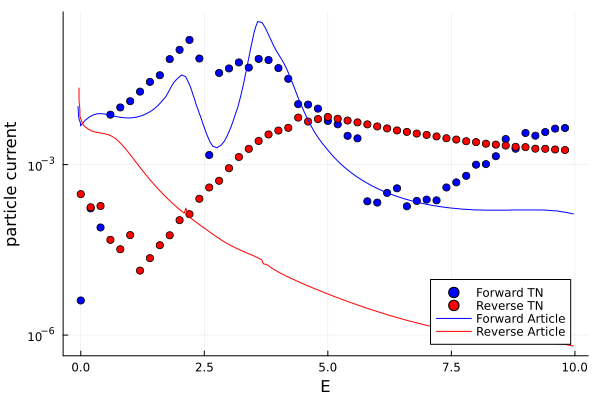

In [14]:
scatter(E_values, JP_F_values, label = "Forward TN", color = "blue")
scatter!(E_values, abs.(JP_R_values), yscale = :log10, label = "Reverse TN", color = "red")
# xlims!(0, 5)

JPF_article = readdlm("Local_Data/Appendix/Article_JForward.txt", ',')
JPR_article = readdlm("Local_Data/Appendix/Article_JReverse.txt", ',')

plot!(JPF_article[:,1], JPF_article[:, 2], yscale = :log10, label = "Forward Article", color = "blue")
plot!(JPR_article[:,1], JPR_article[:, 2], yscale = :log10, label = "Reverse Article", legend=:bottomright, color = "red")

ylabel!("particle current")
xlabel!("E")

In [4]:
function Logarithmic_linear_arrays(L, J)
    #L: lead size
    #J: Spectral density    
    
    #We need to define εk for the lead. In particular, we use the logarithmic-linear discretization of the paper. As this is just for the article, it is not worthy to put it with the other functions in NonInteacting_functions.jl
    
    W_log = W #W
    W_lin = W_log/2 #W* = W/2
    
    L_log = L*0.2
    L_lin = L - L_log
    
    Lin_Window = LinRange(-W_lin, W_lin, Int(L_lin))
    Log_Window = maprange(log, W_lin, W_log, length=Int(L_log/2 + 1))
    
    εk = Float64[]
    append!(εk, -reverse( Log_Window[2:length(Log_Window)]), Lin_Window, Log_Window[2:length(Log_Window)])
    
    γk = [εk[k+1] - εk[k] for k=1:Int(L/2)]
    append!(γk, reverse(γk))

    κkp = ComplexF64[sqrt(J(εk[k])*γk[k]/(2.0*pi)) for k=1:L] #Kp = sqrt(J(e)*γ/(2*pi))

    return εk, γk,  κkp
end

Logarithmic_linear_arrays (generic function with 1 method)

In [18]:
GPU = false

#Lead
L = 10
εk, γk, κkp = Logarithmic_linear_arrays(L, J)
fk_L , fk_R = fk_arrays(εk, εk)

#System
D = N
R = L
M = L + D + R
sites = siteinds("S=1/2",2*M)
I_vec = Build_left_vacuum(sites);

In [19]:
dt = 0.05
NumSteps = 1000
maxdim = 40
cutoff = 10e-12
Measurements = ["JP"]
Percentage_for_measurement = 1.0

Params = Params_for_Measurements(Percentage_for_measurement, εk, γk, κkp, fk_L, εk, γk, κkp, fk_R, ε_array, ts, U, dt); #Empty arrays are for left lead and 0.0 are for ts, U
Swap_Gates, TEBD_Gates = Build_Gates(sites, εk, γk, 0*κkp, fk_L, εk, γk, 0*κkp, fk_R, ε_array, ts, U, dt);
@time Thermal_State, observables = Apply_TEBD(I_vec, I_vec, Swap_Gates, TEBD_Gates, NumSteps, maxdim, cutoff, Measurements, Params); #maxdim = 40 by default
@show observables.JP_t[end]
@show observables.JE_t[end];

10.0 % Completed.
20.0 % Completed.
30.0 % Completed.
40.0 % Completed.
50.0 % Completed.
60.0 % Completed.
70.0 % Completed.
80.0 % Completed.
90.0 % Completed.
100.0 % Completed.
 59.022613 seconds (415.30 M allocations: 112.056 GiB, 9.87% gc time, 0.13% compilation time: 100% of which was recompilation)
observables.JP_t[end] = -9.960286563779975e-15
observables.JE_t[end] = 1.9866194856966065e-14


In [16]:
GPU = true
I_vec = gpu(I_vec)
Thermal_state = gpu(Thermal_State)

dt = 0.05
NumSteps = 500

Params = Params_for_Measurements(Percentage_for_measurement, εk, γk, κkp, fk_L, εk, γk, κkp, fk_R, ε_array, ts, U, dt); #Empty arrays are for left lead and 0.0 are for ts, U
Swap_Gates, TEBD_Gates = Build_Gates(sites, εk, γk, κkp, fk_L, εk, γk, κkp, fk_R, ε_array, ts, U, dt);
@time NESS, observables = Apply_TEBD(Thermal_state, I_vec, Swap_Gates, TEBD_Gates, NumSteps, maxdim, cutoff, Measurements, Params); #maxdim = 40 by default
@show observables.JP_t[end]
@show observables.JE_t[end];

10.0 % Completed.
Effective GPU memory usage: 25.50% (2.039 GiB/7.996 GiB)
Memory pool usage: 228.037 MiB (896.000 MiB reserved)
20.0 % Completed.
Effective GPU memory usage: 25.89% (2.070 GiB/7.996 GiB)
Memory pool usage: 60.690 MiB (928.000 MiB reserved)
30.0 % Completed.
Effective GPU memory usage: 25.89% (2.070 GiB/7.996 GiB)
Memory pool usage: 102.889 MiB (928.000 MiB reserved)
40.0 % Completed.
Effective GPU memory usage: 25.89% (2.070 GiB/7.996 GiB)
Memory pool usage: 145.690 MiB (928.000 MiB reserved)
50.0 % Completed.
Effective GPU memory usage: 26.28% (2.101 GiB/7.996 GiB)
Memory pool usage: 185.446 MiB (960.000 MiB reserved)
60.0 % Completed.
Effective GPU memory usage: 26.67% (2.132 GiB/7.996 GiB)
Memory pool usage: 216.173 MiB (992.000 MiB reserved)
70.0 % Completed.
Effective GPU memory usage: 26.67% (2.132 GiB/7.996 GiB)
Memory pool usage: 236.499 MiB (992.000 MiB reserved)
80.0 % Completed.
Effective GPU memory usage: 26.67% (2.132 GiB/7.996 GiB)
Memory pool usage: 249.

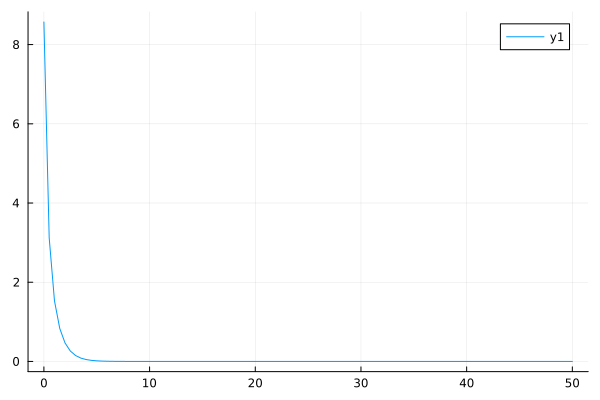

In [20]:
plot(observables.time, observables.JP_t)

In [21]:
observables.JP_t

101-element Vector{Float64}:
  8.570513419320472
  3.1226014445966856
  1.530975256267695
  0.8331156073325419
  0.4662186635640998
  0.26270603051404867
  0.14827688985758933
  0.08372409518157665
  0.047279085794514036
  0.02669916328090048
  0.015077475192371521
  0.008514519935580785
  0.0048083032287914275
  ⋮
  1.1292554193330165e-14
  8.818342881308386e-15
  6.217248937900877e-15
  1.0975347614865832e-14
 -5.3290705182007506e-15
 -8.75490156561552e-15
  4.758098676964956e-15
 -3.172065784643304e-15
  4.504333414193492e-15
 -5.646277096665082e-15
 -9.198990775465583e-15
 -9.960286563779975e-15